In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Aug 10 13:17:46 2022

@author: BetzLab-Admin
"""
import sys
sys.path.append('../../lib')

from time import sleep
from pipython import GCSDevice
from pipython import pitools
from scipy.signal import fftconvolve
import keyboard
from math import cos, sin, pi
import numpy as np
from pycromanager import Core,Studio
from detection_methods import trajectory_corr, trajectory_gauss, trajectory_mean,trajectory_till, trajectory_till_stepwise,most_common_value, compare_trajectories, plt_accuracy_results, trajectory_polar_comparison,save_result, load_result
from detection_methods import make_test_trajectory as make_movie
import matplotlib.pyplot as plt
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage import label
import csv
import random
import os
import pandas as pd
from microscope_functions import snap_image, move_large_stage, calibration_matrix, center_crop, fullscreen, center_object

#from pipython.datarectools import getservotime
core=Core()
core.set_exposure(100)


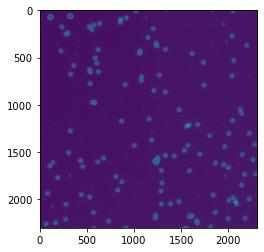

In [3]:
fullscreen()
img_0=snap_image()
plt.imshow(img_0)

In [4]:
matrix=calibration_matrix('big_stage_fixed_calibration_images/fit_parameters_refined.json')
pixel_to_motor=np.linalg.inv(matrix[::-1, ::-1].T)

In [5]:
def maximum_to_center(calibration_file='big_stage_fixed_calibration_images/fit_parameters_refined.json'):
    matrix=calibration_matrix(calibration_file)
    pixel_to_motor=np.linalg.inv(matrix[::-1, ::-1].T)
    img_0=snap_image()
    max_y, max_x = np.unravel_index(np.argmax(img_0), img_0.shape)
    position = np.array([max_x,max_y])
    center=np.array([img_0.shape[1]/2,img_0.shape[0]/2])
    vector_to_center=center-position
    motor_steps=pixel_to_motor@vector_to_center
    move_large_stage(motor_steps[1],motor_steps[0])
    img_1=snap_image()
    max_y, max_x = np.unravel_index(np.argmax(img_1), img_1.shape)
    position = np.array([max_x,max_y])
    vector_to_center=center-position
    motor_steps=pixel_to_motor@vector_to_center
    move_large_stage(motor_steps[1],motor_steps[0]*0.25)
    return

In [7]:
img_uncentered=snap_image()
maximum_to_center()
img_centered=snap_image()
center_crop()
img_cropped=snap_image()


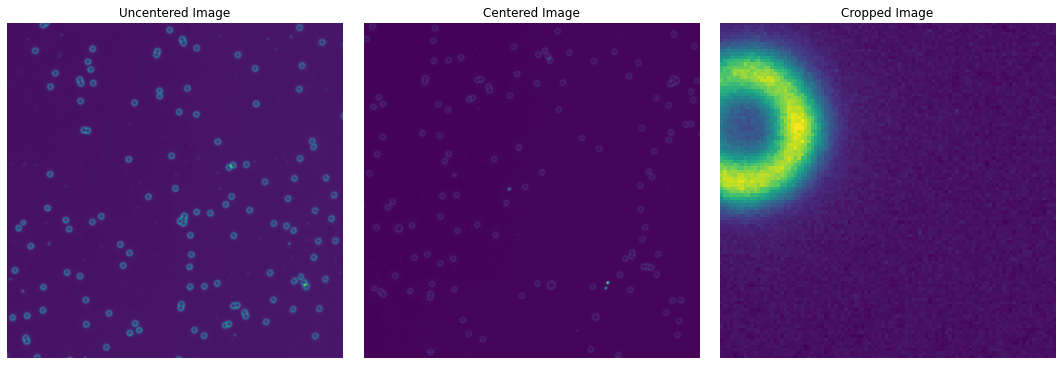

In [8]:
# Display the images side-by-side
fig, axes = plt.subplots(1, 3, figsize=(15,5))

# Show the uncentered image
axes[0].imshow(img_uncentered)
axes[0].set_title("Uncentered Image")
axes[0].axis('off')

# Show the centered image
axes[1].imshow(img_centered)
axes[1].set_title("Centered Image")
axes[1].axis('off')

# Show the cropped image
axes[2].imshow(img_cropped)
axes[2].set_title("Cropped Image")
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [6]:
import numpy as np
from scipy.ndimage import label, maximum_filter
from scipy.signal import fftconvolve

def modified_gaussian_kernel(sigma, truncate=4.0):
    size = int(truncate * sigma + 0.5) * 2 + 1
    y, x = np.mgrid[-size // 2 + 1:size // 2 + 1, -size // 2 + 1:size // 2 + 1]
    g = np.exp(-(x**2 + y**2) / (2.0 * sigma**2))
    g = g / g.sum()
    g = g - g.mean()
    return g

def convolve_with_kernel(image, kernel):
    return fftconvolve(image, kernel, mode='same')

def threshold_image(image, factor=0.1):
    return image > (np.max(image) * factor)

def get_local_maxima(image, size):
    return maximum_filter(image, size=size) == image

def get_labeled_peaks(image):
    return label(image)
def get_central_peak(labeled_peaks, num_peaks, image_shape):
    center = np.array(image_shape) / 2

    # Get all labeled peak coordinates
    peak_coords = np.column_stack(np.where(labeled_peaks > 0))
    
    # Get the center for each labeled peak
    peak_centers = np.array([peak_coords[labeled_peaks[peak_coords[:,0], peak_coords[:,1]] == i].mean(axis=0) for i in range(1, num_peaks+1)])
    
    # Compute the distance from the image center for each peak center
    distances = np.linalg.norm(peak_centers - center, axis=1)
    
    # Find the index of the peak with the smallest distance
    closest_peak_idx = np.argmin(distances)

    return tuple(peak_centers[closest_peak_idx])





def find_modified_gaussian_peak(image, sigma=16):
    kernel = modified_gaussian_kernel(sigma)
    convolved_image = convolve_with_kernel(image, kernel)
    peaks = threshold_image(convolved_image)
    local_max = get_local_maxima(convolved_image, sigma)
    peaks = peaks & local_max
    labeled_peaks, num_peaks = get_labeled_peaks(peaks)
    return get_central_peak(labeled_peaks, num_peaks, image.shape)


In [7]:
fullscreen()
image=snap_image()
sigma=16
kernel = modified_gaussian_kernel(sigma)
convolved_image = convolve_with_kernel(image, kernel)
peaks = threshold_image(convolved_image)
local_max = get_local_maxima(convolved_image, sigma)
peaks = peaks & local_max
labeled_peaks, num_peaks = get_labeled_peaks(peaks)

In [8]:
central_peak = get_central_peak(labeled_peaks, num_peaks, image.shape)

In [9]:



plt.figure(figsize=(10, 10))

# Display the image
plt.imshow(image, cmap='gray')

# Scatter plot of the peaks
for i in range(1, np.max(labeled_peaks) + 1):
    y, x = np.where(labeled_peaks == i)
    plt.scatter(x, y, s=40, c='red', marker='x') # Mark the peaks with red 'x'

plt.title("Image with Detected Peaks")
plt.scatter(central_peak[1],central_peak[0], s=100, c='green', marker='x') # Mark the central peak with a green circle


In [10]:
def beat_to_center(calibration_file='big_stage_fixed_calibration_images/fit_parameters_refined.json'):
    matrix=calibration_matrix(calibration_file)
    pixel_to_motor=np.linalg.inv(matrix[::-1, ::-1].T)
    img_0=snap_image()
    max_y, max_x = find_modified_gaussian_peak(img_0)
    position = np.array([max_x,max_y])
    center=np.array([img_0.shape[1]/2,img_0.shape[0]/2])
    vector_to_center=center-position
    motor_steps=pixel_to_motor@vector_to_center
    move_large_stage(motor_steps[1],motor_steps[0])
    img_1=snap_image()
    max_y, max_x =find_modified_gaussian_peak(img_1)
    position = np.array([max_x,max_y])
    vector_to_center=center-position
    motor_steps=pixel_to_motor@vector_to_center
    move_large_stage(motor_steps[1],motor_steps[0]*0.25)
    return

In [11]:
img_uncentered=snap_image()
beat_to_center()
img_centered=snap_image()
center_crop()
img_cropped=snap_image()


In [12]:
# Display the images side-by-side
fig, axes = plt.subplots(1, 3, figsize=(15,5))

# Show the uncentered image
axes[0].imshow(img_uncentered)
axes[0].set_title("Uncentered Image")
axes[0].axis('off')

# Show the centered image
axes[1].imshow(img_centered)
axes[1].set_title("Centered Image")
axes[1].axis('off')

# Show the cropped image
axes[2].imshow(img_cropped)
axes[2].set_title("Cropped Image")
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [110]:


# Test the function
img_before = snap_image()
centered_img = center_object()

# Plot before and after
fig, axarr = plt.subplots(1, 2, figsize=(12, 6))

# Display the image before
axarr[0].imshow(img_before, cmap='gray')
axarr[0].set_title('Image Before Centering')
axarr[0].scatter(img_before.shape[1]/2, img_before.shape[0]/2, s=100, c='green', marker='x') # Mark the center with a green circle

# Display the centered image
axarr[1].imshow(centered_img, cmap='gray')
axarr[1].set_title('Image After Centering')
axarr[1].scatter(centered_img.shape[1]/2, centered_img.shape[0]/2, s=100, c='green', marker='x') # Mark the center with a green circle

plt.tight_layout()
plt.show()


C:\Users\BETZLA~1\AppData\Local\Temp/ipykernel_18924/999871576.py:34: RuntimeWarning: invalid value encountered in true_divide
  return (data - np.min(data)) / (np.max(data) - np.min(data))


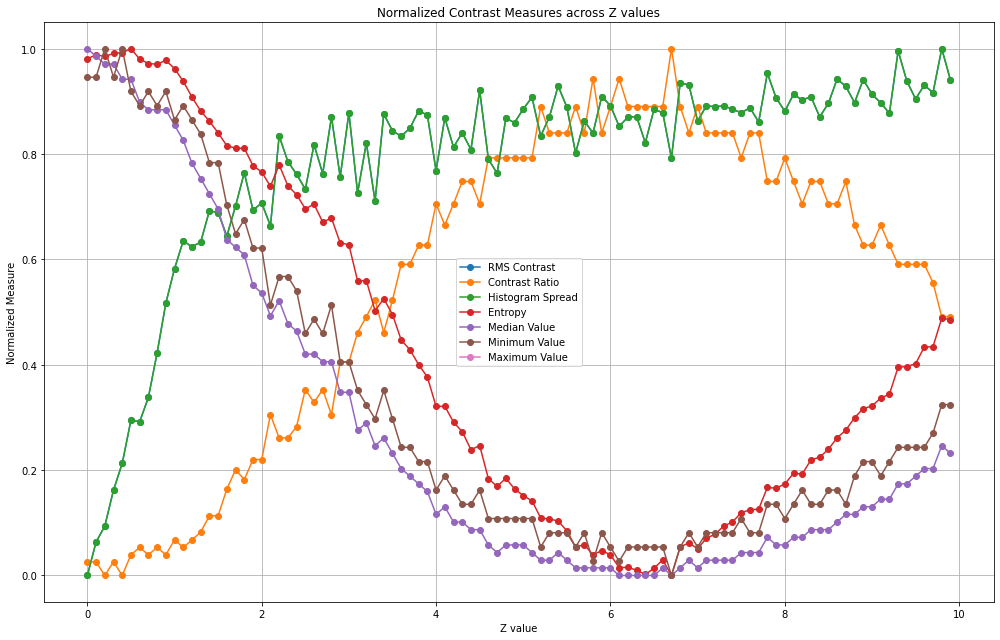

In [116]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize lists for each measure
z_list = []
rms_list = []
contrast_ratio_list = []
histogram_spread_list = []
entropy_list = []
median_list = []
min_list = []
max_list = []

z = 0
core.set_exposure(500)

def rms_contrast(image):
    mean_intensity = np.mean(image)
    return np.sqrt(np.mean((image - mean_intensity)**2))

def contrast_ratio(image):
    return image.max() / image.min()

def histogram_spread(image):
    return np.std(image)

def entropy(image):
    hist = np.histogram(image, bins=256)[0]
    hist = hist / np.sum(hist)
    hist = hist[hist > 0]
    return -np.sum(hist * np.log2(hist))

def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

for i in range(100):
    z_list.append(z)
    img = snap_image()
    
    rms_list.append(rms_contrast(img))
    contrast_ratio_list.append(contrast_ratio(img))
    histogram_spread_list.append(histogram_spread(img))
    entropy_list.append(entropy(img))
    median_list.append(np.median(img))
    min_list.append(np.min(img))
    max_list.append(np.max(img))
    
    z += 0.1
    move_z_direction(0.1)

# Normalize the measures
rms_list = normalize(rms_list)
contrast_ratio_list = normalize(contrast_ratio_list)
histogram_spread_list = normalize(histogram_spread_list)
entropy_list = normalize(entropy_list)
median_list = normalize(median_list)
min_list = normalize(min_list)
max_list = normalize(max_list)

# Plotting
plt.figure(figsize=(14, 9))

plt.plot(z_list, rms_list, label='RMS Contrast', marker='o')
plt.plot(z_list, contrast_ratio_list, label='Contrast Ratio', marker='o')
plt.plot(z_list, histogram_spread_list, label='Histogram Spread', marker='o')
plt.plot(z_list, entropy_list, label='Entropy', marker='o')
plt.plot(z_list, median_list, label='Median Value', marker='o')
plt.plot(z_list, min_list, label='Minimum Value', marker='o')
plt.plot(z_list, max_list, label='Maximum Value', marker='o')

plt.xlabel('Z value')
plt.ylabel('Normalized Measure')
plt.title('Normalized Contrast Measures across Z values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


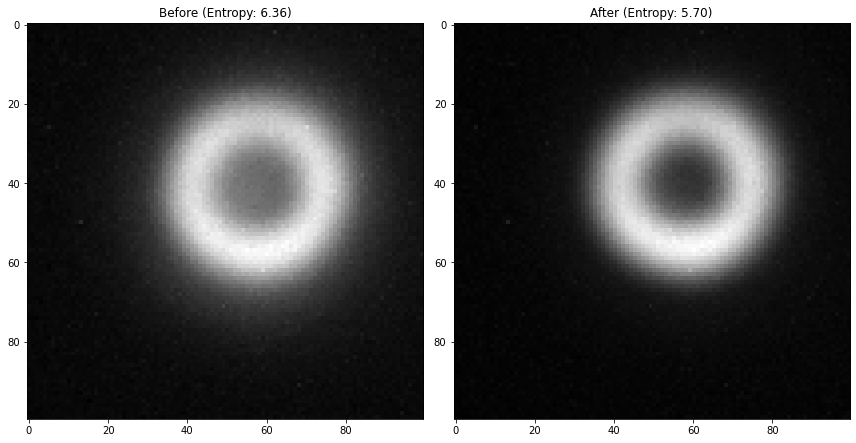

In [128]:
import matplotlib.pyplot as plt

def plot_image_before_after():
    # Take the initial image and measure its entropy
    img_before = snap_image()
    entropy_before = entropy(img_before)
    
    # Move to the optimal z-position using the previously defined function
    for i in range(3):
        optimal_z_position()
    
    
    # Take an image after the adjustment
    img_after = snap_image()
    entropy_after = entropy(img_after)
    
    # Plot images side by side
    fig, axarr = plt.subplots(1, 2, figsize=(12, 6))
    
    # Display the image before adjustment
    axarr[0].imshow(img_before, cmap='gray')
    axarr[0].set_title(f'Before (Entropy: {entropy_before:.2f})')
    
    # Display the image after adjustment
    axarr[1].imshow(img_after, cmap='gray')
    axarr[1].set_title(f'After (Entropy: {entropy_after:.2f})')
    
    plt.tight_layout()
    plt.show()

# Execute the function to see the result
plot_image_before_after()


In [78]:
file ="Y:\\Julian\\fixed_beat_experiments\\location_validation_experiments\\exposure_200\\datapoint_5\\movie.npy"

In [79]:
import numpy as np
movie=np.load(file,allow_pickle=True)

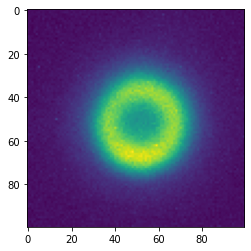

In [80]:
import matplotlib.pyplot as plt
plt.imshow(movie[2])